In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import data
import viz
outcome_def = 'iai_intervention' # output
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# combined

In [15]:
df_pecarn, df_psrc, common_feats, filtered_feats_pecarn, filtered_feats_psrc = data.load_it_all(dummy=True)
df = df_pecarn[common_feats].append(df_psrc[common_feats])
processed_feats = data.select_final_feats(common_feats, collapse_abd_tender=True, collapse_abd_distention=True)
# df_pecarn = df_pecarn[df_pecarn.cv_fold.isin(data.pecarn_train_idxs)]
# df_psrc = df_psrc[df_psrc.cv_fold.isin(data.psrc_train_idxs)]
processed_feats

/accounts/projects/vision/.local/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


['AbdDistention_or_AbdomenPain_yes',
 'AbdTenderDegree_None',
 'AbdTrauma_or_SeatBeltSign_yes',
 'Age',
 'CostalTender_yes',
 'DecrBreathSound_yes',
 'GCSScore_Full_yes',
 'Hypotension_yes',
 'InitHeartRate',
 'InitSysBPRange',
 'MOI_Bike collision/fall',
 'MOI_Fall from an elevation',
 'MOI_Motor vehicle collision',
 'MOI_Motorcycle/ATV/Scooter collision',
 'MOI_Object struck abdomen',
 'MOI_Pedestrian/bicyclist struck by moving vehicle',
 'ThoracicTrauma_yes',
 'VomitWretch_yes']

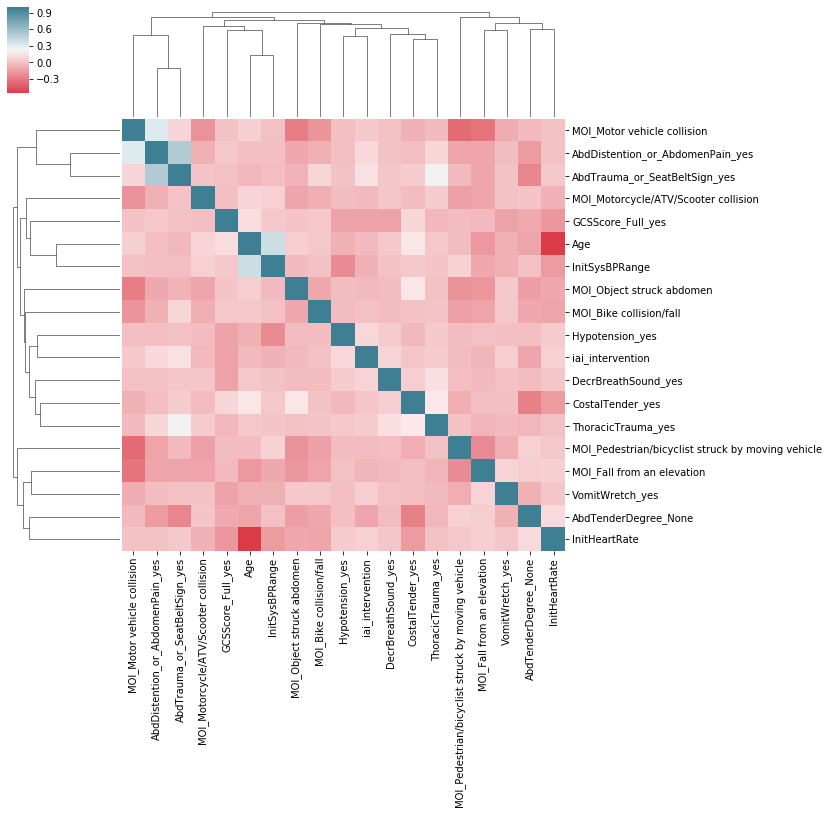

In [16]:
# corrs = df[feat_names + [outcome_def]].corr()
corrs = df[processed_feats + [outcome_def]].corr(method='spearman')
sns.clustermap(corrs, cmap=viz.cmap_div)
# plt.savefig('results/corrplot.png', dpi=300, bbox_inches='tight')

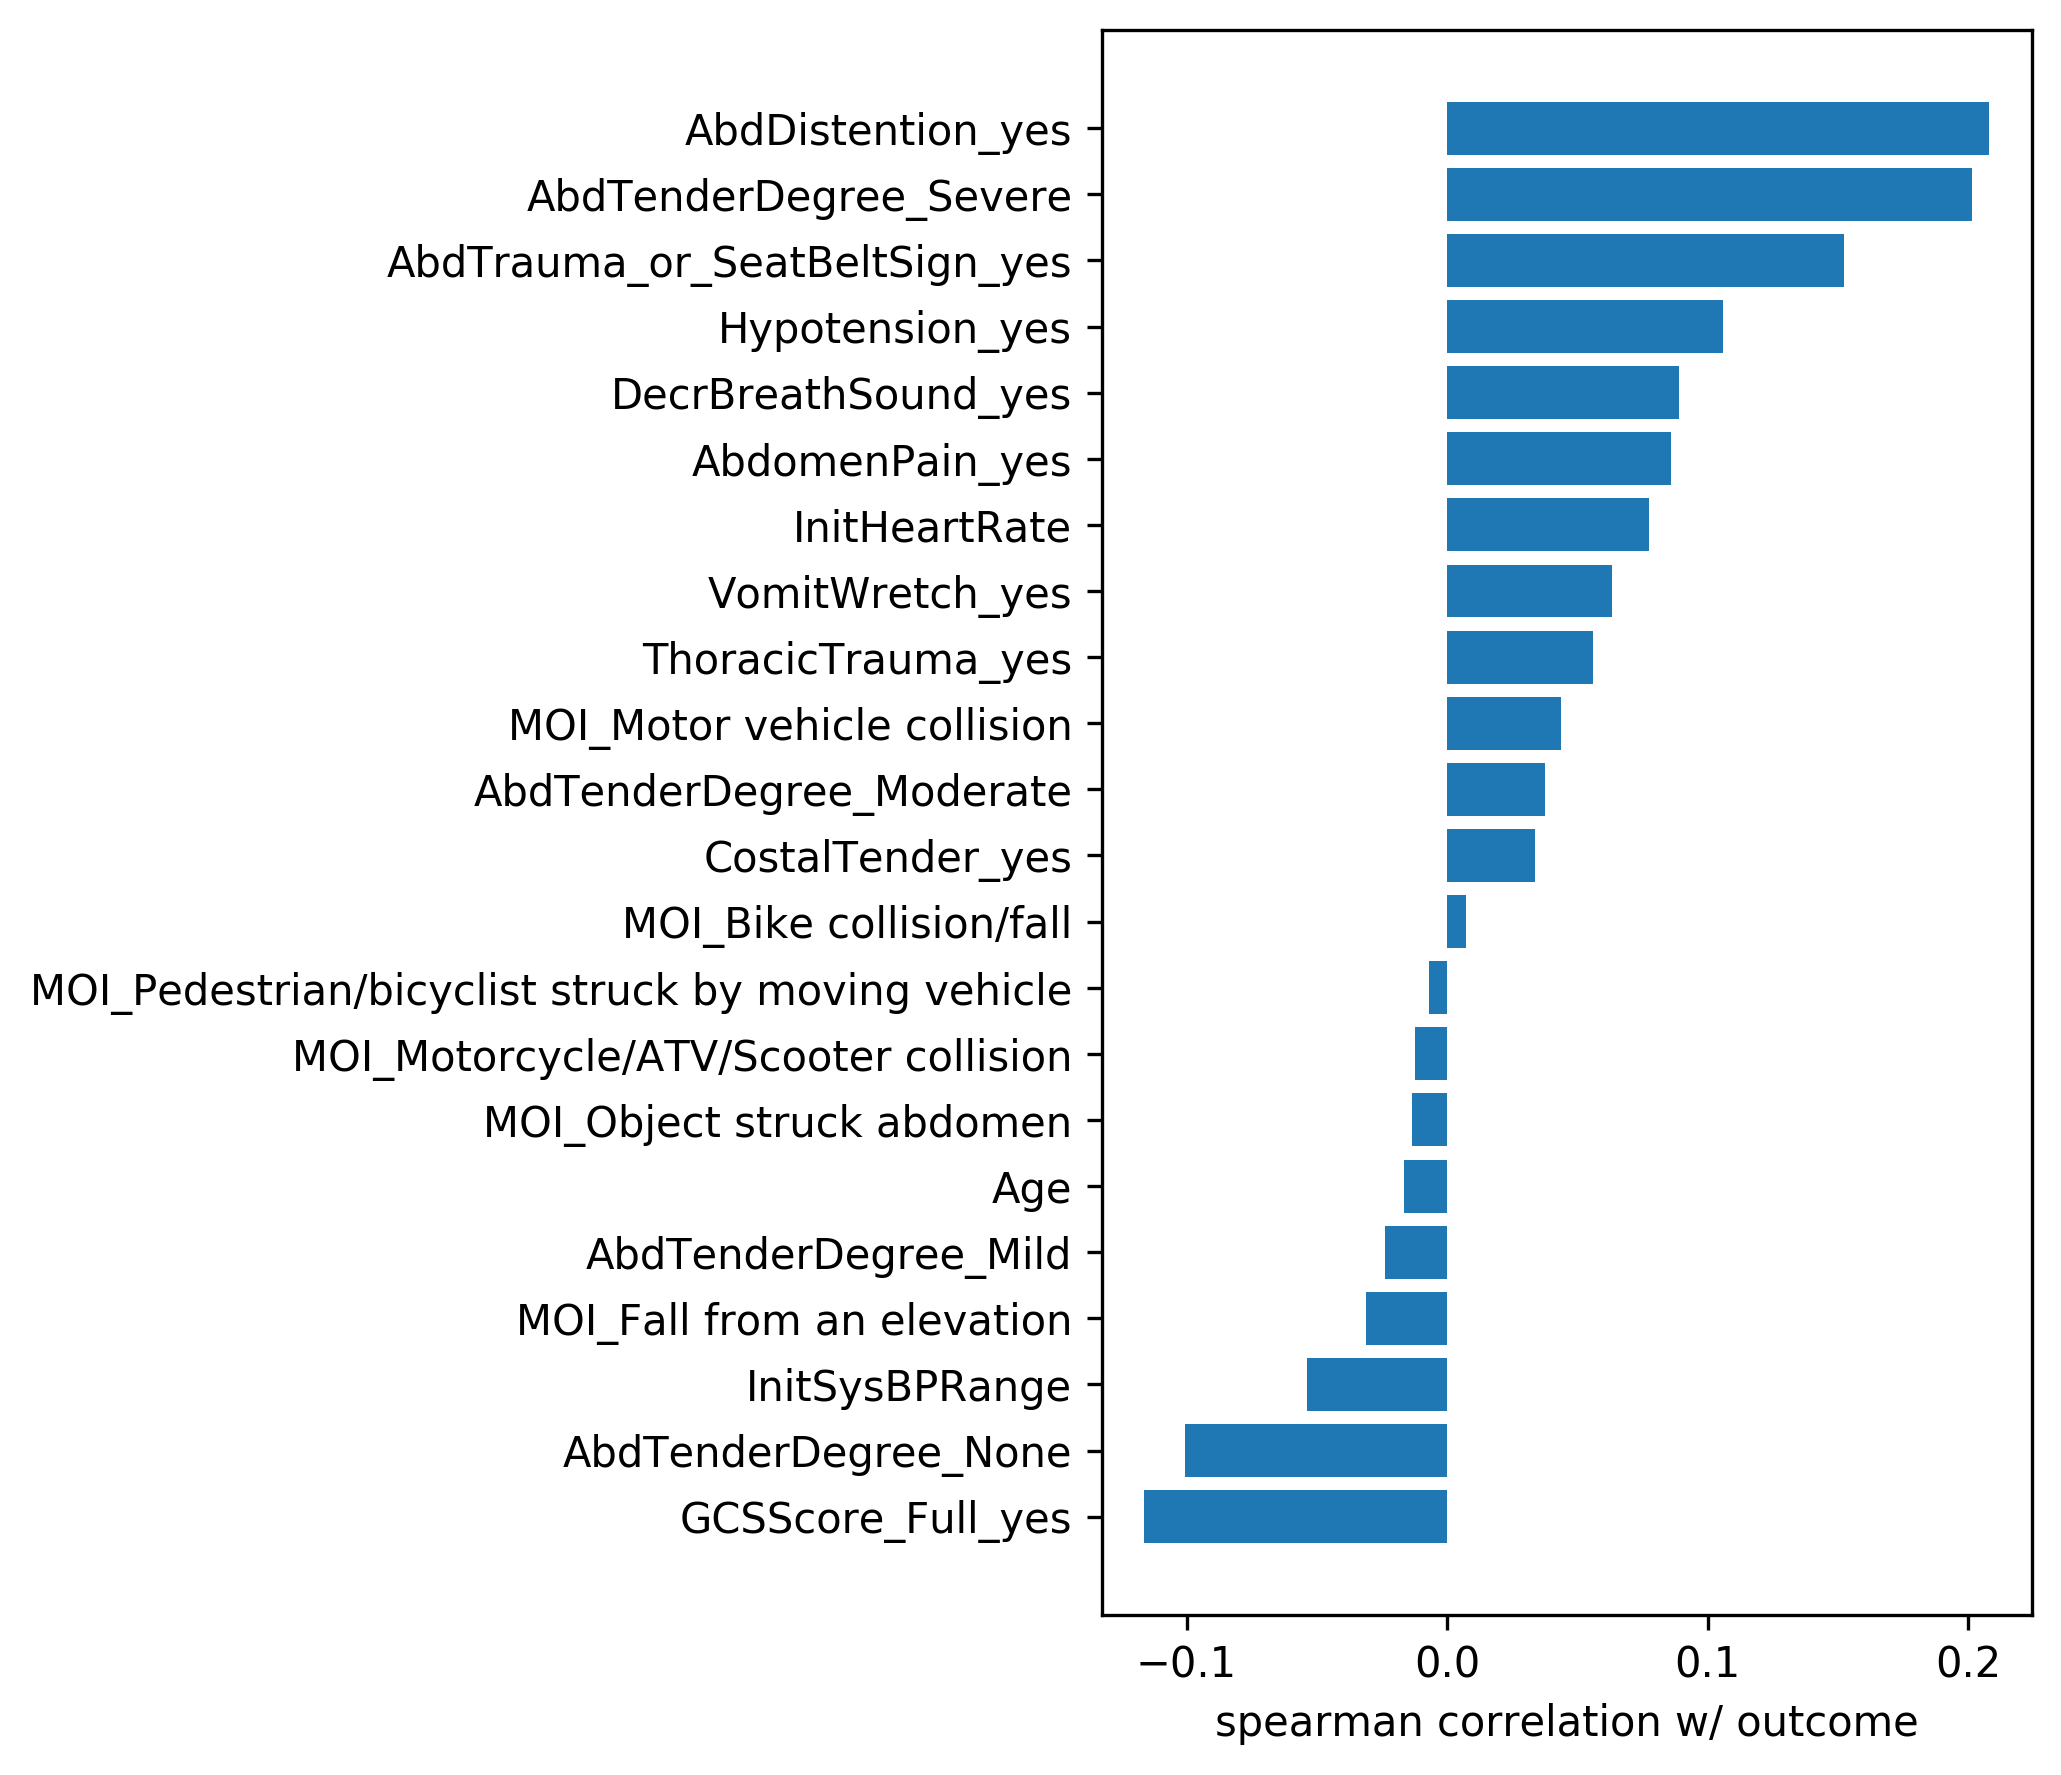

In [14]:
plt.figure(dpi=300, figsize=(4, 7))
vals = corrs[outcome_def]
args = np.argsort(vals)
labs = corrs['iai_intervention'][args].index.values
plt.barh(labs[:-1], vals[args][:-1])
plt.xlabel('spearman correlation w/ outcome')
plt.show()

# features scatter plots

## continuous features

In [ ]:
R, C, = 1, 4
plt.figure(figsize=(12, 3), dpi=500)
for i in range(len(data.feats_numerical)):
    plt.subplot(R, C, i + 1)
    feat = data.feats_numerical[i]
    plt.hist(df[df[outcome_def] == 1][feat], density=True, alpha=1, label='pos', color=cb)
    plt.hist(df[df[outcome_def] == 0][feat], density=True, alpha=0.5, label='neg', color=cr)
    plt.xlabel(feat, fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

**we can cut GCSScore as whether it is 15 or not (14 is already pretty bad)**

In [6]:
feat = 'GCSScore'
print(np.unique(df[df[outcome_def] == 1][feat], return_counts=True))
print(np.unique(df[df[outcome_def] == 0][feat], return_counts=True))

(array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.]), array([ 40,   2,   3,   6,  10,   4,  10,   7,   1,   1,   9,  25, 147]))
(array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.]), array([  303,    40,    37,    82,    80,    57,    80,    75,    76,
         108,   283,   743, 12003]))


# scatter plots

In [ ]:
viz.jointplot_grouped('Age', 'InitSysBPRange', 'iai_intervention', df)

In [8]:
# viz.jointplot_grouped('Age', 'AbdDistention_yes', 'iai_intervention', df)

In [ ]:
viz.jointplot_grouped('InitSysBPRange', 'InitHeartRate', 'iai_intervention', df)

In [ ]:
viz.jointplot_grouped('Age', 'Hypotension_yes', 'iai_intervention', df)

In [ ]:
viz.jointplot_grouped('Age', 'Sex_M', 'iai_intervention', df_pecarn) # this is using the df that still has gender